## Tropical Cyclone Intensity Model using Decision Tree Classifier

This Jupyter Notebook trains a decision tree classifier to predict the 6-hourly intensity changes for tropical cyclones.  Since the majority of tropical cyclone intensities are recorded in 5 knot increments, a decision tree classifier is a suitable first model to try for this task.

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn import tree
import seaborn as sns
import matplotlib.pyplot as plt
from utils import print_data_types, print_target_percentage_numerical
from sklearn.metrics import confusion_matrix

Viewing your data is a crucial step in any data analysis or machine learning project. It helps you understand the structure, quality, and nuances of your dataset, which can significantly impact the performance of your models.  I typically look at the data from multiple perspectives.  A few individual examples, the data types of the features (model inputs), and some simple statistics for the features.  This helps me start to identify any issues or patterns that may affect the model's performance.


### Data
This data comes from the SHIPS dataset.  The features (or model inputs) are:
1. vs0: Maximum sustained wind speed (knots)
2. VMPI_t0: Maximum potential intensity (knots)
3. SHRD: Vertical wind shear (knots)
4. DELV-6: The last 6-hour intensity change (knots)
5. E000_t0: 1000 hPa theta_e (radius=200-800km) vs time (deg K*10)
6. DTL_t6: Distance to land (km)
7. lat: Latitude (degrees) of the storm center
8. lon: Longitude (degrees) of the storm center

The target is dvs6: The 6-hour intensity change (knots).  This is the variable we want to predict.

In [2]:
# Load the intensity models dataset from csv and display the first few rows to get a first look at the data
# precomputed and filtered dataset of 9 variables that can be used to predict intensity change
all_data_df = pd.read_csv("input_data/NOAA_SHIPS_9vars_all_data.csv")  
all_data_df.head()

# drop the columns that are not needed for training (year, basin, type, month, day, hour)
all_data_df = all_data_df.drop(columns=['year', 'basin', 'type', 'month', 'day', 'hour'])

In [3]:
# print out the data types from each column in the dataframe
print_data_types(all_data_df)

# print out the summary statistics of the dataframe
all_data_df.describe(include='all', percentiles=[0.1, 0.25, 0.5, 0.75, 0.9])

-------------------------
 Column Name   Data Type
-------------------------
 vs0             float64
 VMPI_t0         float64
 U200_t0         float64
 SHRD_t0         float64
 DELV-6          float64
 E000_t0         float64
 DTL_t6          float64
 lat             float64
 lon             float64
 dvs6            float64
-------------------------


vs0       VMPI_t0       U200_t0       SHRD_t0        DELV-6  \
count  75333.000000  75333.000000  75333.000000  75333.000000  75333.000000   
mean      53.010142    124.605514      2.064789    157.698724      0.450348   
std       27.945369     35.007403    147.748082     97.037180      6.261103   
min       10.000000      0.000000   -417.000000      0.000000    -70.059617   
10%       25.000000     75.000000   -163.000000     53.000000     -5.004258   
25%       30.000000    112.000000   -101.000000     88.000000      0.000000   
50%       45.000000    135.000000    -22.000000    140.000000      0.000000   
75%       65.000000    148.000000     82.000000    206.000000      5.004258   
90%       95.000000    156.000000    202.000000    281.000000      5.004258   
max      185.000000    196.000000   1001.000000    912.000000     55.046842   

            E000_t0        DTL_t6           lat           lon          dvs6  
count  75333.000000  75333.000000  75333.000000  75333.000000  75333.000000  
mean    3496.535679    797.402117     12.466959     22.566929      0.169306  
std       71.632200    706.255724     16.257971    110.651408      6.430893  
min     2964.000000  -1008.594661    -38.800000   -180.000000    -70.059617  
10%     3409.000000     45.000000    -16.000000   -119.100000     -5.004258  
25%     3464.000000    234.000000     10.200000    -91.400000     -5.000000  
50%     3505.000000    607.000000     16.100000     62.200000      0.000000  
75%     3542.000000   1280.000000     21.900000    127.800000      5.000000  
90%     3575.000000   1866.000000     30.000000    149.300000      5.004258  
max     3744.000000   4149.000000     54.000000    179.900000     55.046842

Next, I checkout the different types of intensity changes present in this dataset to see how many categories this model will need to identify.  I round the intnesity changes to 5 knot increments (the format the majority of values are in), and remove some outliers.

In [4]:
# print the percentage of each target 'dvs6' in the dataset.  Here we see that the dataset has a lot of very similar but not identical values.
print_target_percentage_numerical(all_data_df, 'dvs6')

---------------------------------
 Target  |  Percentage  |  Count
---------------------------------
  0.000  |      44.57%  |  33579
  5.004  |      13.41%  |  10104
 -5.004  |      10.80%  |   8138
  5.000  |       5.42%  |   4083
 -5.000  |       3.80%  |   2860
 10.009  |       3.24%  |   2442
-10.009  |       2.97%  |   2235
 10.000  |       1.70%  |   1280
  5.004  |       1.53%  |   1155
-10.000  |       1.44%  |   1084
 -5.004  |       1.05%  |    789
 10.009  |       0.90%  |    675
-10.009  |       0.73%  |    553
 -5.004  |       0.73%  |    553
 15.013  |       0.73%  |    549
-15.013  |       0.72%  |    539
-15.000  |       0.51%  |    381
 15.000  |       0.44%  |    328
 10.009  |       0.42%  |    314
-10.009  |       0.38%  |    288
 -5.004  |       0.35%  |    261
 15.013  |       0.28%  |    213
  5.004  |       0.27%  |    200
-15.013  |       0.25%  |    191
-20.017  |       0.23%  |    172
-20.000  |       0.21%  |    157
-20.017  |       0.20%  |    148
 20.017 

In [5]:
# round the target data 'dvs6' to the nearest 5 to reduce the number of targets
all_data_df['dvs6'] = all_data_df['dvs6'].apply(lambda x: round(x/5)*5)
print_target_percentage_numerical(all_data_df, 'dvs6')

---------------------------------
 Target  |  Percentage  |  Count
---------------------------------
  0.000  |      44.58%  |  33583
  5.000  |      21.16%  |  15944
 -5.000  |      17.06%  |  12849
 10.000  |       6.32%  |   4763
-10.000  |       5.58%  |   4207
-15.000  |       1.69%  |   1272
 15.000  |       1.62%  |   1217
-20.000  |       0.64%  |    483
 20.000  |       0.51%  |    381
-25.000  |       0.26%  |    196
 25.000  |       0.20%  |    147
-30.000  |       0.12%  |     90
-35.000  |       0.07%  |     56
 30.000  |       0.07%  |     50
-40.000  |       0.04%  |     30
 35.000  |       0.03%  |     25
 40.000  |       0.01%  |      8
-55.000  |       0.01%  |      8
-50.000  |       0.01%  |      6
-45.000  |       0.01%  |      5
 50.000  |       0.01%  |      4
-65.000  |       0.00%  |      3
-60.000  |       0.00%  |      2
 45.000  |       0.00%  |      2
-70.000  |       0.00%  |      1
 55.000  |       0.00%  |      1

Total count:   75333
Unique targets:   2

In [6]:
# only keep target values between -30 and 30 and remove the outliers as there isn't enough samples to support a good train/test split.
all_data_df = all_data_df[(all_data_df['dvs6'] >= -30) & (all_data_df['dvs6'] <= 30)]
print_target_percentage_numerical(all_data_df, 'dvs6')

# now that the data is represented as 5 knot increments, it is looking like a great candidate for a classification model with 13 classes.

---------------------------------
 Target  |  Percentage  |  Count
---------------------------------
  0.000  |      44.67%  |  33583
  5.000  |      21.21%  |  15944
 -5.000  |      17.09%  |  12849
 10.000  |       6.34%  |   4763
-10.000  |       5.60%  |   4207
-15.000  |       1.69%  |   1272
 15.000  |       1.62%  |   1217
-20.000  |       0.64%  |    483
 20.000  |       0.51%  |    381
-25.000  |       0.26%  |    196
 25.000  |       0.20%  |    147
-30.000  |       0.12%  |     90
 30.000  |       0.07%  |     50

Total count:   75182
Unique targets:   13
---------------------------------


Now that I've viewed numerical values of the data and I'm satisfied with the target variable, I can visualize the distributions to get a different view of the data.  This can help me identify any patterns or issues that I may not have noticed before.

array([[<Axes: title={'center': 'vs0'}>,
        <Axes: title={'center': 'VMPI_t0'}>,
        <Axes: title={'center': 'U200_t0'}>],
       [<Axes: title={'center': 'SHRD_t0'}>,
        <Axes: title={'center': 'DELV-6'}>,
        <Axes: title={'center': 'E000_t0'}>],
       [<Axes: title={'center': 'DTL_t6'}>,
        <Axes: title={'center': 'lat'}>, <Axes: title={'center': 'lon'}>],
       [<Axes: title={'center': 'dvs6'}>, <Axes: >, <Axes: >]],
      dtype=object)

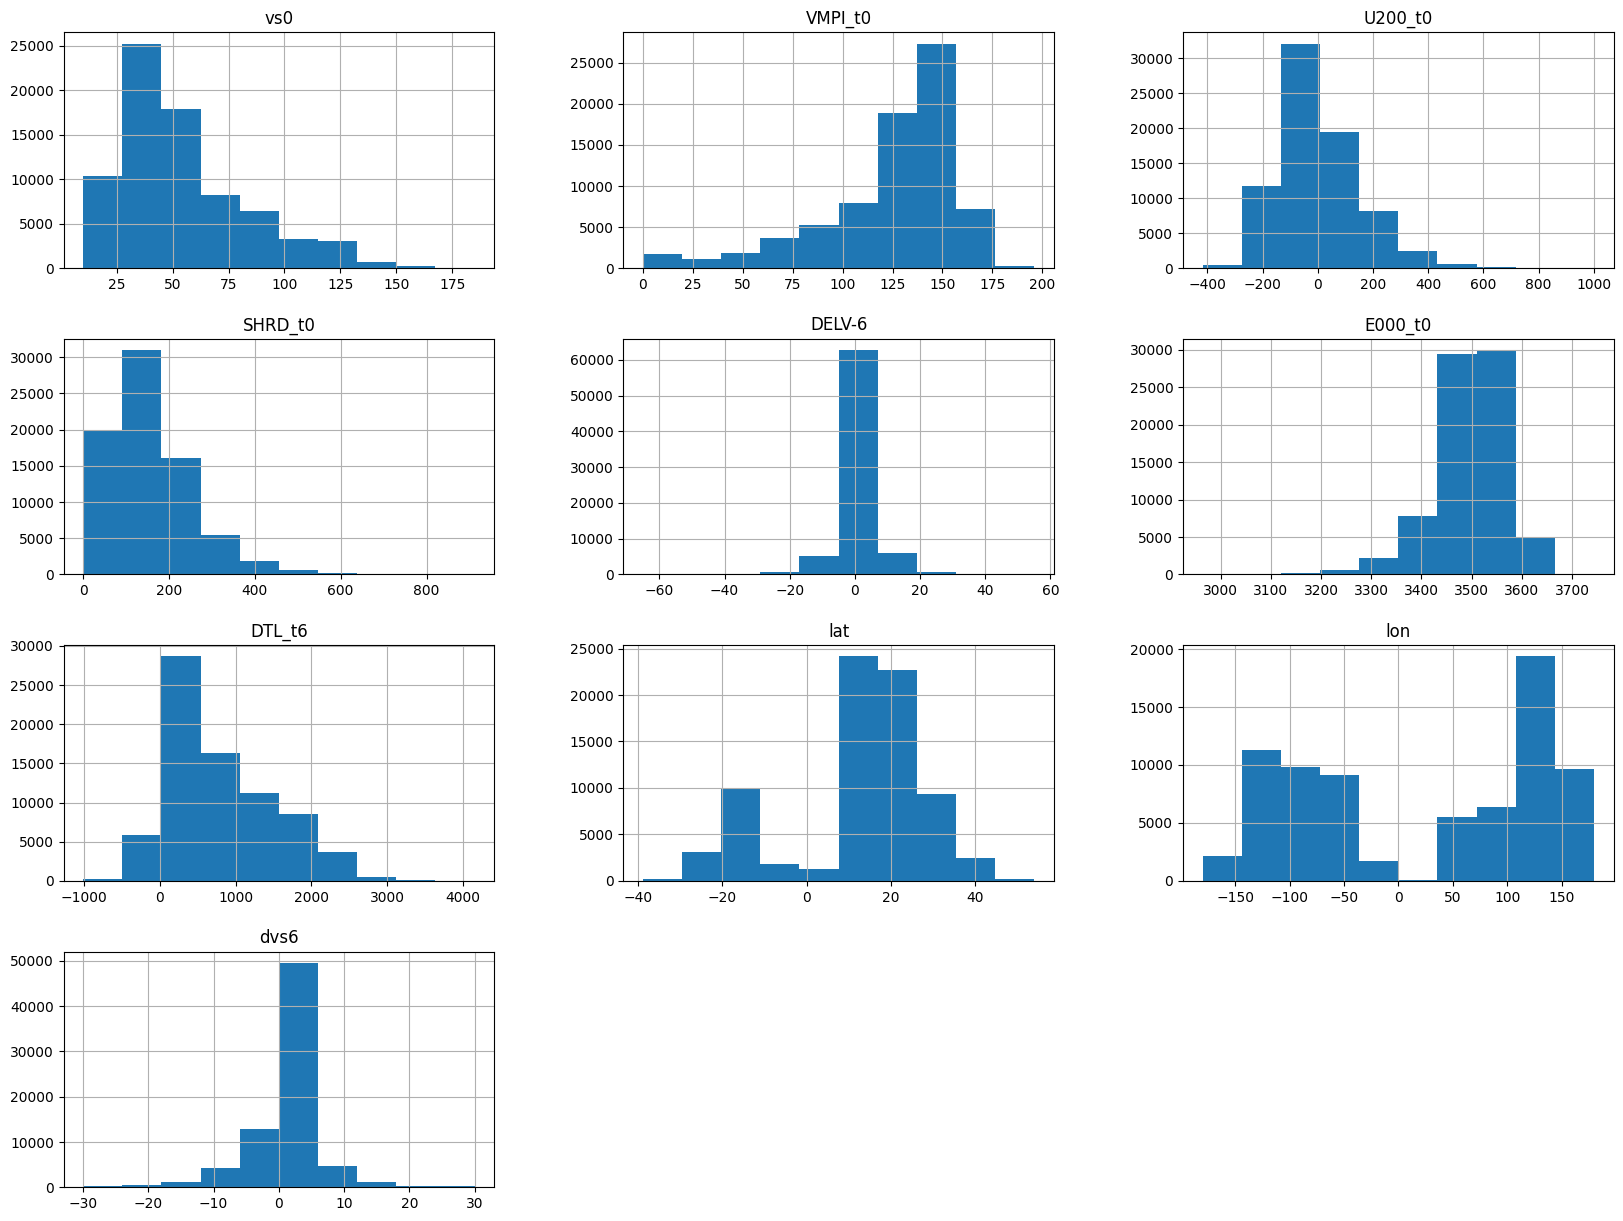

In [7]:
# make a histogram of the features and target to see the distribution of the data
all_data_df.hist(bins=10, figsize=(20, 15))

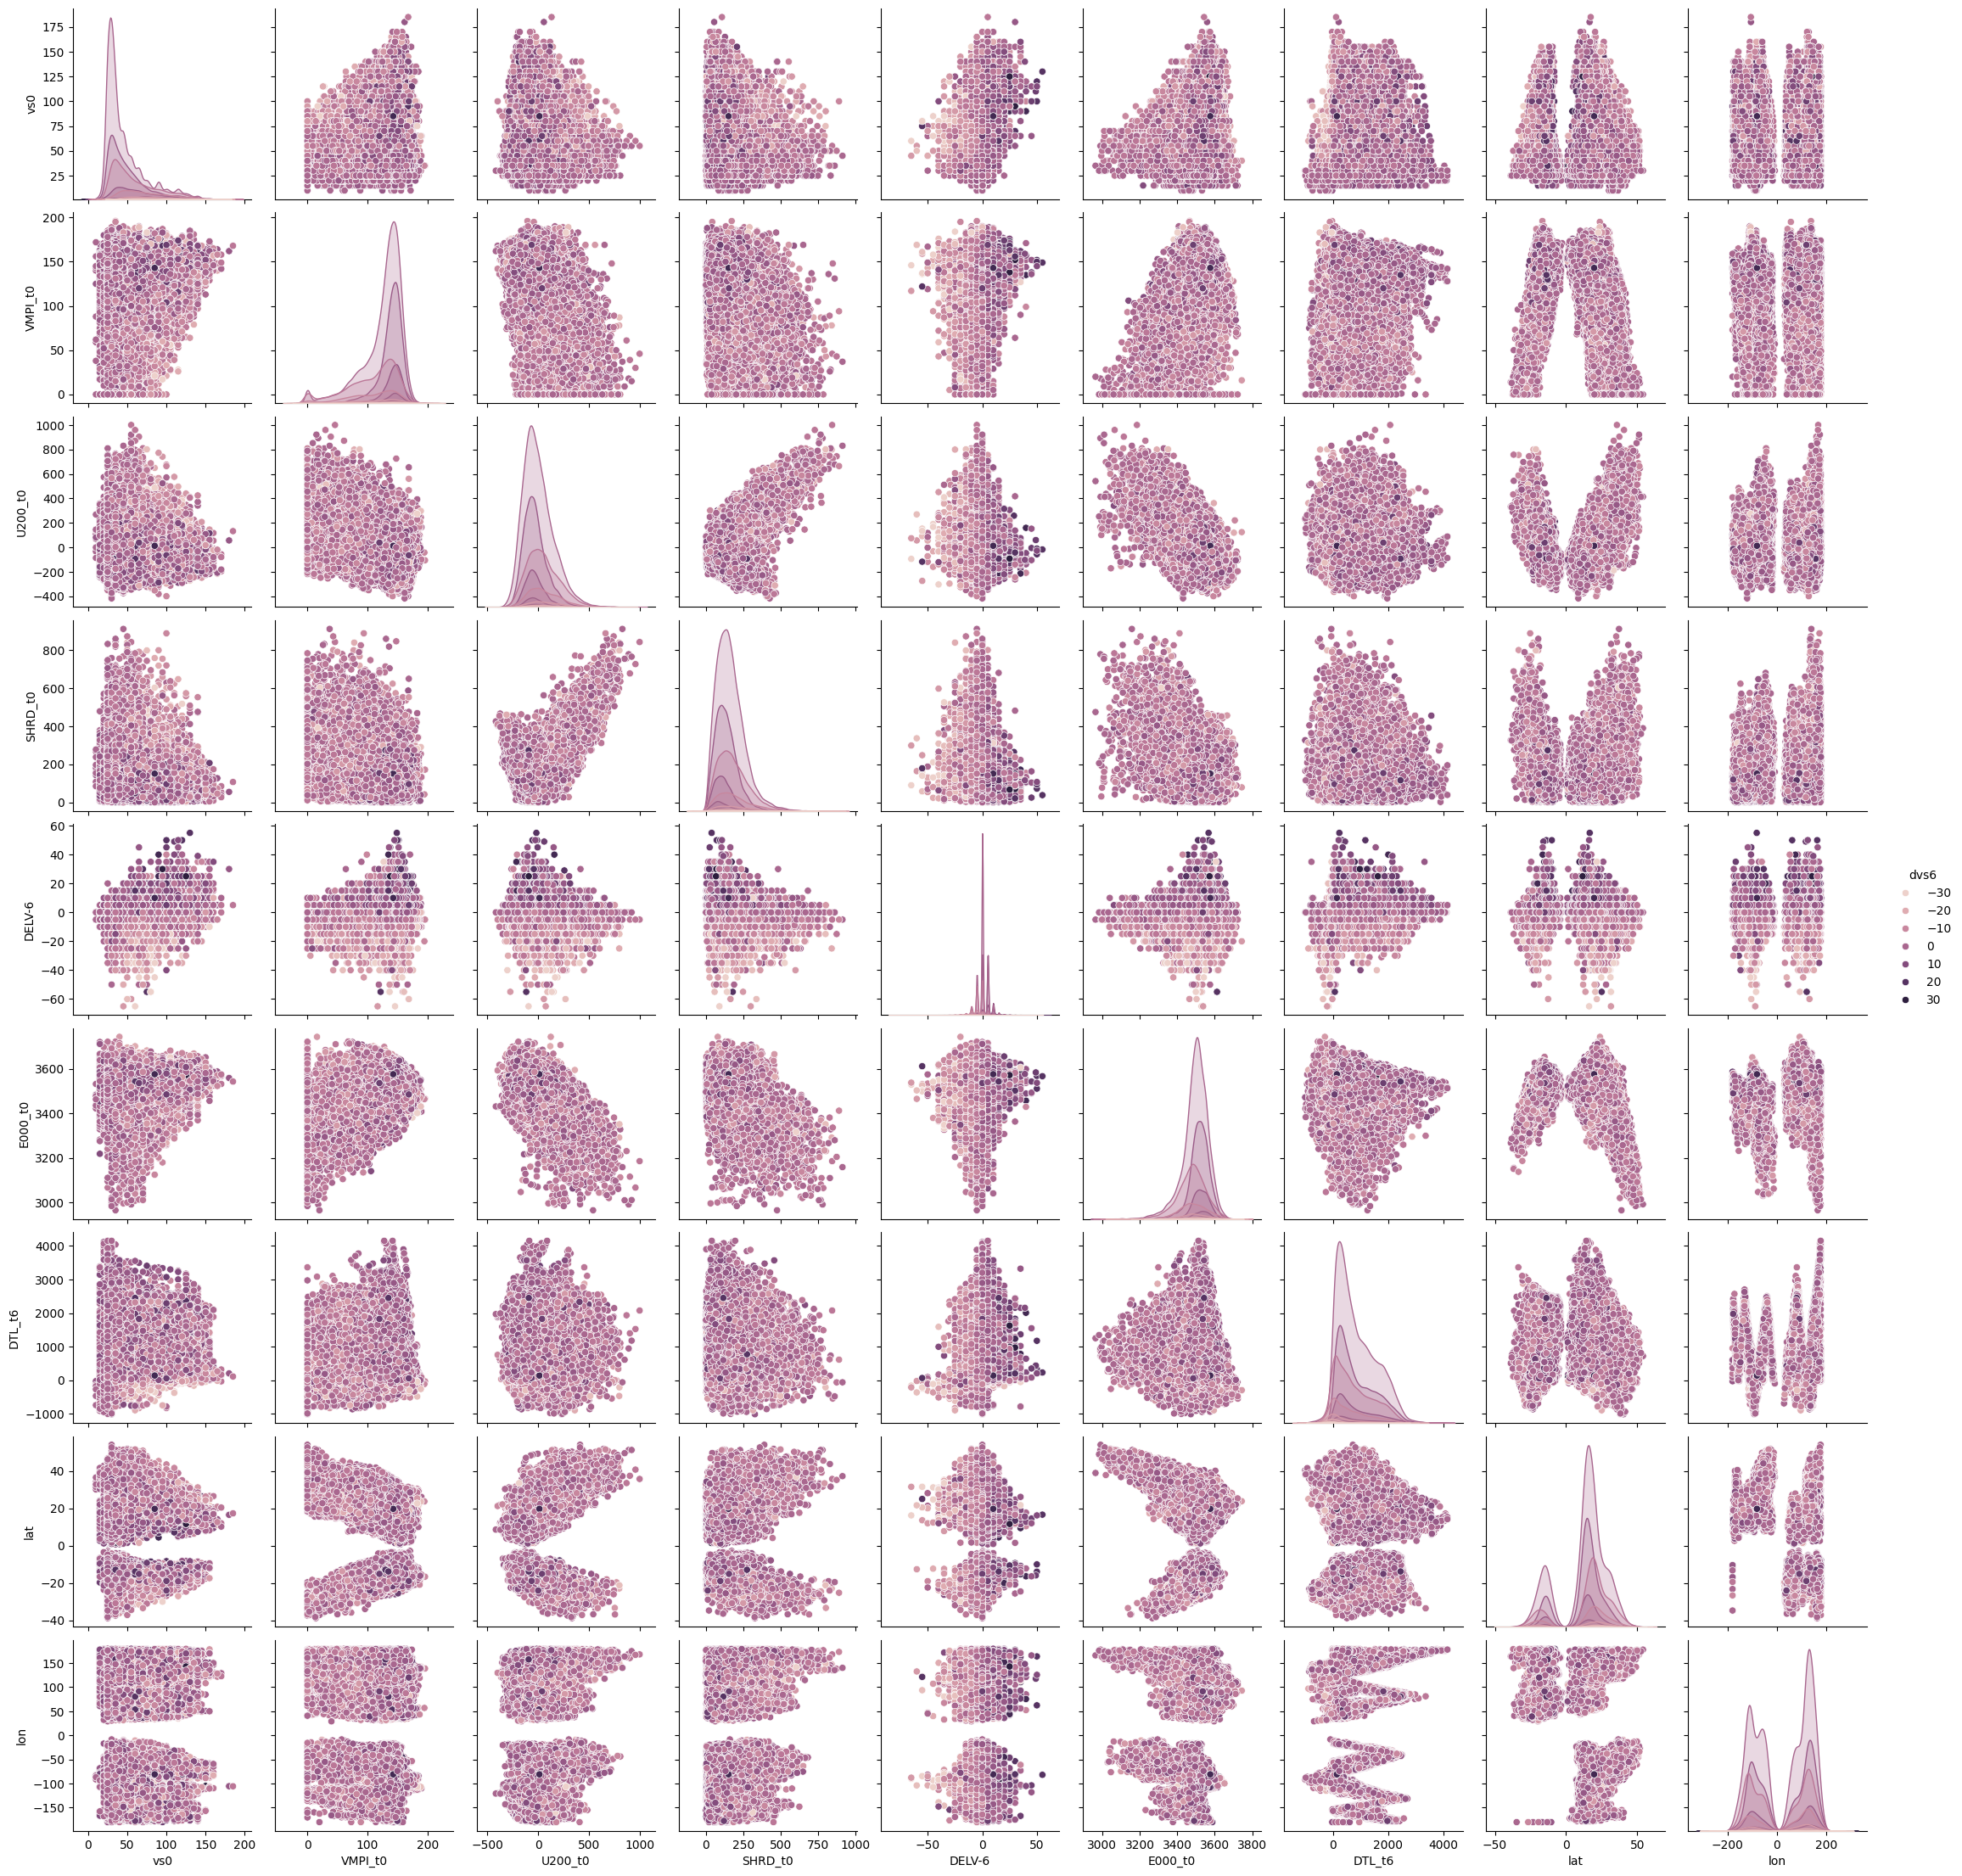

In [8]:
# NOTE: This can take a LONG time to run as there are a lot of features to pair together (15 minutes on my laptop)
# visualize the data using a pairplot to see if there are any obvious relationships between the features and the target.  
# I don't see any but it's worth looking at or saving as a fun picture to check out later.
sns.pairplot(all_data_df, hue='dvs6')

Once we are done visualizing the data, we can move on to splitting the dataset into a training and test set.

In [9]:
# separate the data into features and target
features = all_data_df.drop(columns='dvs6')
target = all_data_df['dvs6']

print(f"Features: {features.shape}")
print(f"Target: {target.shape}")

# split the data up into a training and test set using a stratified split to keep the target distribution the same
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=112, stratify=target)

Features: (75182, 9)
Target: (75182,)


In [10]:
# check again to ensure the split has equal proportions of the target classes.  i.e. 44% zero change in training and 44% in test
print("Training set")
# represent the pandas series as a dataframe so it can be used with the print_target_percentage_categorical function
print_target_percentage_numerical(pd.DataFrame({'dvs6':y_train}), 'dvs6')
print()

print("Test set")
# represent the pandas series as a dataframe so it can be used with the print_target_percentage_categorical function
print_target_percentage_numerical(pd.DataFrame({'dvs6':y_test}), 'dvs6')
print()

# print the percentage split of the training and test set
print(f"Training set: {X_train.shape}")
print(f"Test set: {X_test.shape}")
print(f"percentage of training set: {X_train.shape[0]/(X_train.shape[0] + X_test.shape[0]):.2f}")
print(f"percentage of test set: {X_test.shape[0]/(X_train.shape[0] + X_test.shape[0]):.2f}")

Training set
---------------------------------
 Target  |  Percentage  |  Count
---------------------------------
  0.000  |      44.67%  |  26866
  5.000  |      21.21%  |  12755
 -5.000  |      17.09%  |  10279
 10.000  |       6.33%  |   3810
-10.000  |       5.59%  |   3365
-15.000  |       1.69%  |   1018
 15.000  |       1.62%  |    974
-20.000  |       0.64%  |    386
 20.000  |       0.51%  |    305
-25.000  |       0.26%  |    157
 25.000  |       0.20%  |    118
-30.000  |       0.12%  |     72
 30.000  |       0.07%  |     40

Total count:   60145
Unique targets:   13
---------------------------------

Test set
---------------------------------
 Target  |  Percentage  |  Count
---------------------------------
  0.000  |      44.67%  |   6717
  5.000  |      21.21%  |   3189
 -5.000  |      17.09%  |   2570
 10.000  |       6.34%  |    953
-10.000  |       5.60%  |    842
-15.000  |       1.69%  |    254
 15.000  |       1.62%  |    243
-20.000  |       0.65%  |     97
 20.0

In [11]:
# create a decision tree classifier
decision_tree_classifier_model = tree.DecisionTreeClassifier(max_depth=4, ccp_alpha=0.0001, random_state=112)
decision_tree_classifier_model.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0001, max_depth=4, random_state=112)

In [12]:
# run the model on the train and test set to evaluate model performance

# Predict on the training set
y_pred_train = decision_tree_classifier_model.predict(X_train)
y_observed_train = y_train.copy()  # make a copy without reference

# calculate test metrics
y_pred_test = decision_tree_classifier_model.predict(X_test)
y_observed_test = y_test.copy()  # make a copy without reference

In [13]:
# However, this is a regression problem that is formatted as a classification problem for simplicity.  Calculate the metrics as if this was a 
# regression problem to see how well the model is predicting the intensity change.

train_mean_error = (y_observed_train - y_pred_train).mean()
train_mean_absolute_error = (y_observed_train - y_pred_train).abs().mean()
train_root_mean_squared_error = ((y_observed_train - y_pred_train)**2).mean()**0.5
print(f"Training Mean Error: {train_mean_error:.2f}")
print(f"Training Mean Absolute Error: {train_mean_absolute_error:.2f}")
print(f"Training Root Mean Squared Error: {train_root_mean_squared_error:.2f}\n")

test_mean_error = (y_observed_test - y_pred_test).mean()
test_mean_absolute_error = (y_observed_test - y_pred_test).abs().mean()
test_root_mean_squared_error = ((y_observed_test - y_pred_test)**2).mean()**0.5
print(f"Test Mean Error: {test_mean_error:.2f}")
print(f"Test Mean Absolute Error: {test_mean_absolute_error:.2f}")
print(f"Test Root Mean Squared Error: {test_root_mean_squared_error:.2f}")

# considering that intensity is measured in 5 knot increments, these metrics show the model doing a great job!  The difference between the training and test
# metrics are also minimal indicating that the model is not overfitting the data.  However...

Training Mean Error: 0.12
Training Mean Absolute Error: 3.27
Training Root Mean Squared Error: 5.18

Test Mean Error: 0.12
Test Mean Absolute Error: 3.23
Test Root Mean Squared Error: 5.09


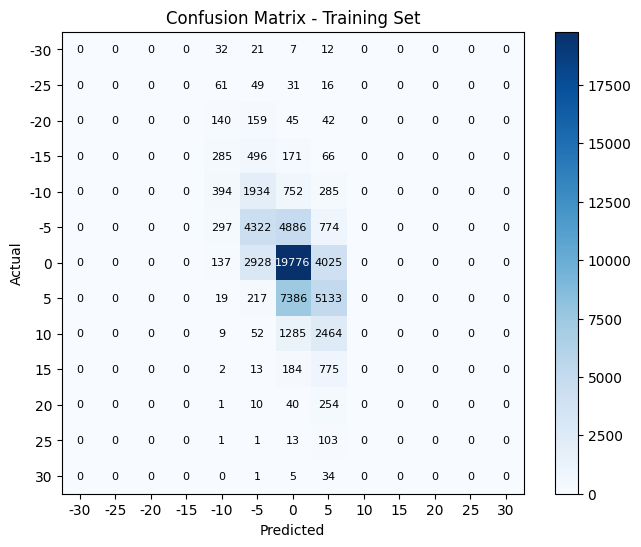

In [14]:
# Even though our problem is a regression problem, the inputs and outputs are formatted as a classification problem which allows us to use a confusion matrix
# to visualize the performance of the model.
# Create a confusion matrix for the training set
conf_matrix = confusion_matrix(y_observed_train, y_pred_train)

plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix, cmap='Blues')
plt.title('Confusion Matrix - Training Set')
plt.colorbar()
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.xticks(ticks=range(conf_matrix.shape[1]), labels=sorted(y_observed_train.unique()))
plt.yticks(ticks=range(conf_matrix.shape[0]), labels=sorted(y_observed_train.unique()))

# Add count to each box with adjusted text color
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        # Adjust text color based on background intensity
        text_color = 'black' if conf_matrix[i, j] < conf_matrix.max() / 2 else 'white'
        plt.annotate(str(conf_matrix[i, j]), xy=(j, i), ha='center', va='center', color=text_color, fontsize=8)

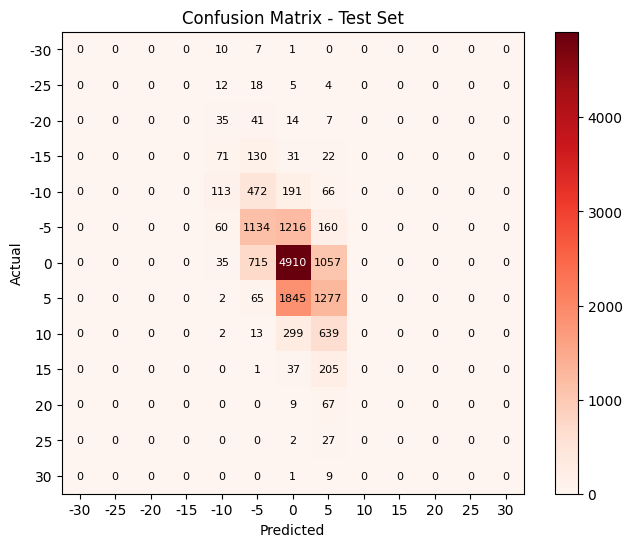

In [15]:
# similarly, plot a confusion matrix of the test set
conf_matrix = confusion_matrix(y_observed_test, y_pred_test)

plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix, cmap='Reds')
plt.title('Confusion Matrix - Test Set')
plt.colorbar()
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.xticks(ticks=range(conf_matrix.shape[1]), labels=sorted(y_observed_test.unique()))
plt.yticks(ticks=range(conf_matrix.shape[0]), labels=sorted(y_observed_test.unique()))

# Add count to each box with adjusted text color
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        # Adjust text color based on background intensity
        text_color = 'black' if conf_matrix[i, j] < conf_matrix.max() / 2 else 'white'
        plt.annotate(str(conf_matrix[i, j]), xy=(j, i), ha='center', va='center', color=text_color, fontsize=8)

Upon review of the regression metrics, you might think this model is doing a great job predicting the 6-hourly intensity change of tropical cyclones, however, due to the overwhelming majority of -5, 0, and 5 knot intensity changes, the model is overfitting to these values and struggles to make predictions beyond this range.  

## **This model performs well on the average 6-hourly intensity change, but cannot predict more extreme intensity changes.**

some things to addressed this skewed model performance:
1. There is a large class imbalance in the dataset, with the majority of examples being "no change" in intensity. This can be addressed by using techniques like oversampling, undersampling, or using class weights in the model.
2. Picking a different model that can handle the skewed class distribution better, such as a Random Forest or Gradient Boosting model.

Other things worth addressing:
1. Not seen as an issue here, but there is most likely a large amount of data leakage between the training and test sets as the data is not separated by storm.  This could be addressed by first splitting the data into complete storms and then splitting the storms into training and test sets.
2. This experiment should actually be split into a training, validation, and test set.  Various hyperparameters should be tuned using the validation set, and the final model should be evaluated on the test set.